In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
def display(x, row, col):
    num_of_images = row * col
    fig, axe = plt.subplots(row, col, figsize=(8, 8))

    for i in range(row):
        for j in range(col):
            axe[i][j].imshow(x[np.random.randint(0, num_of_images), :].reshape(28, 28), origin="upper", cmap="gray",
                             interpolation="nearest")
            axe[i][j].set_xticks([])
            axe[i][j].set_yticks([])
    plt.show()


def plot_loss(loss):
    plt.plot(loss, label='Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()
    
    
def plot_accuracy(acc):
    plt.plot(acc, label='Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.show()

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz
Training set images shape: (55000, 784)
Training set labels shape: (55000, 10)
Test set images shape: (10000, 784)
Test set labels shape: (10000, 10)


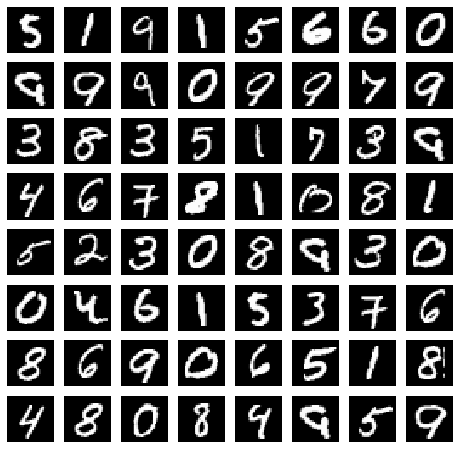

In [0]:
mnist=input_data.read_data_sets("mnist", one_hot=True)

training_set = mnist.train.images
training_labels = np.asarray(mnist.train.labels, dtype=np.int32)
test_set = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

# Shapes of training set
print("Training set images shape: {shape}".format(shape=mnist.train.images.shape))
print("Training set labels shape: {shape}".format(shape=mnist.train.labels.shape))

# Shapes of test set
print("Test set images shape: {shape}".format(shape=mnist.test.images.shape))
print("Test set labels shape: {shape}".format(shape=mnist.test.labels.shape))

# plot 8 by 8 images from the training set randomly
row = 8
col = 8

display(training_set, row, col)

In [0]:
def classification_cnn(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        # TensorFlow’s convolutional conv2d operation expects a 4-dimensional tensor
        #  with dimensions corresponding to batch, width, height and channel.
        inputs = tf.reshape(data, [-1, 28, 28, 1])

        # convolutional layer 1
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        # pooling layer
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=training)

        # convlutional layer 2
        conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=training)

        p2_flat = tf.reshape(dropout2, [-1, 7 * 7 * 64])  # 3136 dims

        # dense layer
        h1 = tf.layers.dense(inputs=p2_flat, units=1024, activation=tf.nn.relu)
        dropout3 = tf.layers.dropout(inputs=h1, rate=0.4, training=training)
        
        # output layer
        outputs = tf.layers.dense(inputs=dropout3, units=10, activation=None)
    return outputs

In [0]:
import math
batch_size = 128
x_dim = 784
num_classes = 10
starting_learning_rate = 0.003
decay_step = 4000
decay_rate = 1.0/math.e
test_labels_idx = tf.argmax(test_labels, axis=1)

with tf.variable_scope('main', reuse=tf.AUTO_REUSE):
  x = tf.placeholder(tf.float32, [batch_size, x_dim])
  y = tf.placeholder(tf.float32, [batch_size, num_classes])
  step = tf.placeholder(tf.int32)
  y_labels = tf.argmax(y, axis=1)
  outputs = classification_cnn(x, training=True)
 
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_labels, logits=outputs)) * 100.0
  
  new_lr = tf.train.exponential_decay(starting_learning_rate, step, decay_step, decay_rate)

  optimiser = tf.train.AdamOptimizer(learning_rate=new_lr).minimize(loss)

  preds = classification_cnn(test_set, training=False)
  predictions = tf.nn.softmax(preds)
  predictions_idx = tf.argmax(predictions, axis=1)
  accuracy, update_op = tf.metrics.accuracy(labels=test_labels_idx, predictions=predictions_idx)

iterations = 20000
with tf.Session() as sess:
  print('Start')
  sess.run(tf.global_variables_initializer())
  sess.run(tf.local_variables_initializer())
  loss_list = []
  accuracy_list = []

  for i in range(iterations):
    batch_data, batch_labels = mnist.train.next_batch(batch_size)
    _, l, acc, acc_op = sess.run([optimiser, loss, accuracy, update_op], feed_dict={x: batch_data, y: batch_labels, step: i})
    loss_list.append(l)
    accuracy_list.append(acc)

    if i % 200 == 0 and i != 0:
      print('Iteration: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(i, l, acc))
      plot_loss(loss_list)
      plot_accuracy(accuracy_list)